# Diabetes Prediction with RandomForestClassifier

A machine learning model is requested to be developed that can predict whether individuals are diabetic based on the specified features. Prior to developing the model, the necessary steps of data analysis and feature engineering are expected to be carried out.

The dataset is a part of a large dataset maintained by the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. It was used for a diabetes study conducted on Pima Indian women aged 21 and above, residing in Phoenix, the 5th largest city in the state of Arizona.

The target variable is defined as "outcome," where 1 indicates a positive result of the diabetes test and 0 indicates a negative result. 

## Dataset Story

* 9 Variables 768 Observations 24 KB
* Pregnancies: Number of pregnancies
* Glucose: Plasma glucose concentration after a 2-hour oral glucose tolerance test
* Blood Pressure: Blood pressure (Diastolic pressure) (mm Hg)
* SkinThickness: Skin thickness
* Insulin: 2-hour serum insulin (mu U/ml)
* DiabetesPedigreeFunction: Function (Plasma glucose concentration after a 2-hour oral glucose tolerance test)
* BMI: Body mass index
* Age: Age (years)
* Outcome: Afflicted with the disease (1) or not (0)

In [1]:
# Libraries 

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
import ydata_profiling as pp
#!pip install missingno
#import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

# Some configurations 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
df_= pd.read_csv("diabetes.csv")

In [3]:
df= df_.copy()
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            2      138             62             35        0 33.600                     0.127   47        0
1            0       84             82             31      125 38.200                     0.233   23        0
2            0      145              0              0        0 44.200                     0.630   31        0
3            0      135             68             42      250 42.300                     0.365   24        0
4            1      139             62             41      480 40.700                     0.536   21        0

# 1. EDA- Explolary Data Analysis 

In [4]:
# lets check to big picture and get to know datas. 
def describe_data(df):
    print("###################### Columns ######################")
    print(df.columns)
    print("######################### Index ########################")
    print(df.index)
    print("######################## Shape #########################")
    print(df.shape)
    print("###################### First 5 Lines ###################")
    print(df.head())
    print("###################### Last 5 Lines ###################")
    print(df.tail())
    print("###################### Types ############################")
    print(df.dtypes)
    print("######################### Info #########################")
    print(df.info())
    print("######################### N/A ##########################")
    print(df.isnull().sum())
    print("######################### Quantiles  ######################")
    print(df.describe().T)

In [5]:
describe_data(df)

###################### Columns ######################
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype='object')
######################### Index ########################
RangeIndex(start=0, stop=2000, step=1)
######################## Shape #########################
(2000, 9)
###################### First 5 Lines ###################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            2      138             62             35        0 33.600                     0.127   47        0
1            0       84             82             31      125 38.200                     0.233   23        0
2            0      145              0              0        0 44.200                     0.630   31        0
3            0      135             68             42      250 42.300                     0.365   24        0
4            1      139     

In [6]:
# lets check to categorical and numerical features 
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car= grab_col_names(df)

Observations: 2000
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


Insight: 
2000 observations, 9 variables.
1 categorical column, 8 numerical columns.
Categorical as Numeric: 0 columns.
Numeric as Categorical: 1 column.

In [8]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [9]:
cat_cols

['Outcome']

In [10]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# lets check to numerical features
%matplotlib inline
def num_summary(dataframe, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 1]
    for col in num_cols:  # num_cols = grab_col_names(dataframe)["num_cols"]
        print("########## Summary Statistics of " + col + " ############")
        print(dataframe[col].describe(quantiles))
        
        if plot:
            sns.histplot(data=dataframe, x=col)
            plt.xlabel(col)
            plt.title("The distribution of " + col)
            plt.grid(True)  
            plt.show(block=True)
            plt.title("The boxplot of " + col)
            sns.boxplot(x=df[col])
            plt.show(block=True)

########## Summary Statistics of Pregnancies ############
count   2000.000
mean       3.704
std        3.306
min        0.000
5%         0.000
10%        0.000
20%        1.000
30%        1.000
40%        2.000
50%        3.000
60%        4.000
70%        5.000
80%        7.000
90%        9.000
95%       10.000
100%      17.000
max       17.000
Name: Pregnancies, dtype: float64


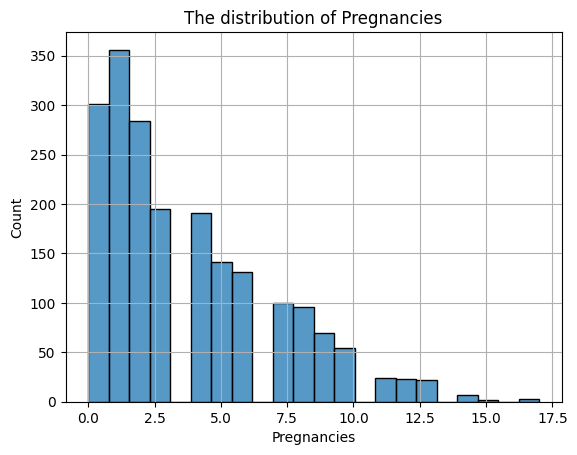

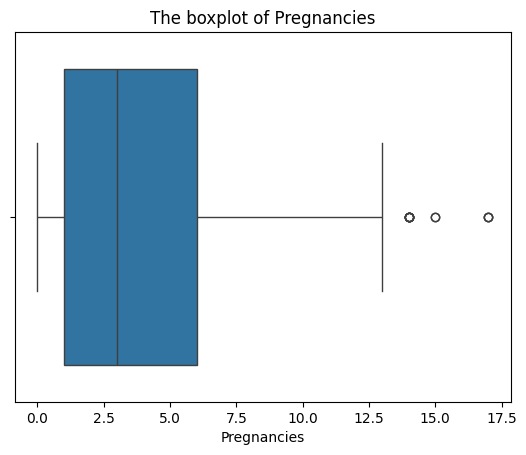

########## Summary Statistics of Glucose ############
count   2000.000
mean     121.183
std       32.069
min        0.000
5%        80.000
10%       85.000
20%       95.000
30%      102.000
40%      109.000
50%      117.000
60%      125.000
70%      136.000
80%      147.000
90%      168.000
95%      181.000
100%     199.000
max      199.000
Name: Glucose, dtype: float64


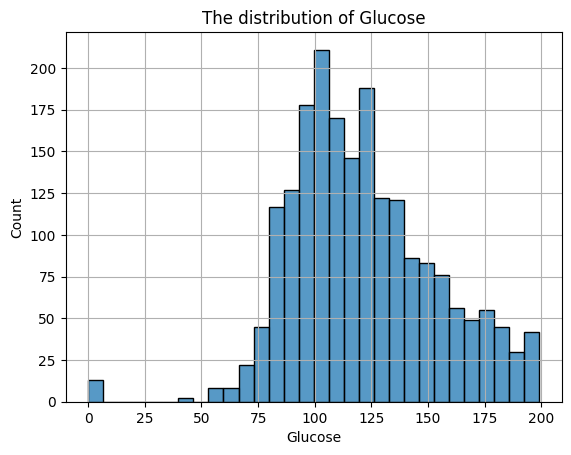

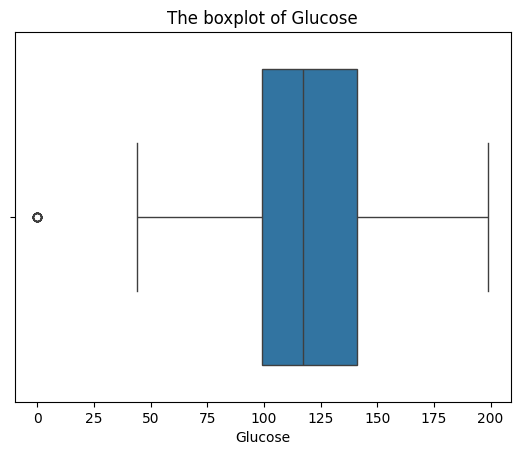

########## Summary Statistics of BloodPressure ############
count   2000.000
mean      69.145
std       19.188
min        0.000
5%        43.800
10%       54.000
20%       60.000
30%       64.000
40%       68.000
50%       72.000
60%       74.000
70%       78.000
80%       82.000
90%       88.000
95%       90.000
100%     122.000
max      122.000
Name: BloodPressure, dtype: float64


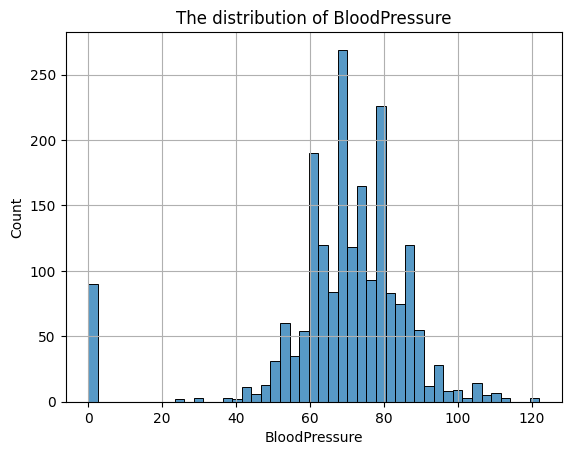

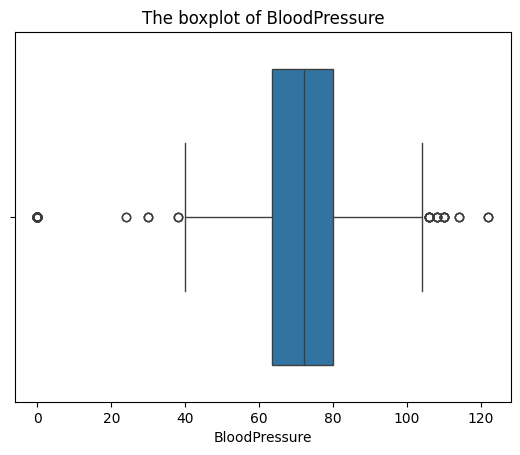

########## Summary Statistics of SkinThickness ############
count   2000.000
mean      20.935
std       16.103
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%       11.000
40%       18.000
50%       23.000
60%       28.000
70%       31.000
80%       35.000
90%       40.000
95%       44.050
100%     110.000
max      110.000
Name: SkinThickness, dtype: float64


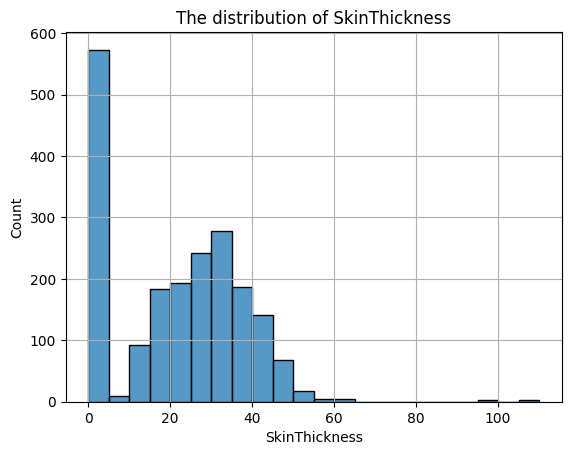

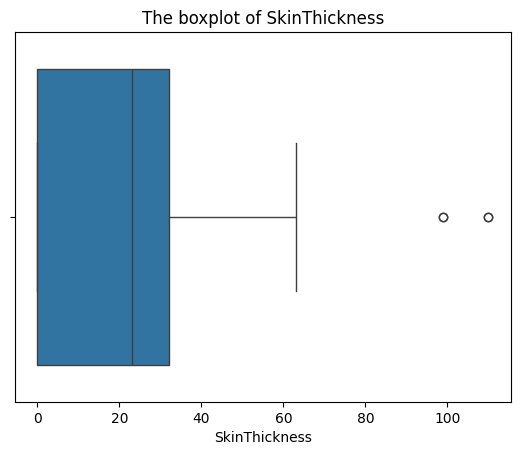

########## Summary Statistics of Insulin ############
count   2000.000
mean      80.254
std      111.181
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       40.000
60%       75.400
70%      110.000
80%      155.000
90%      210.000
95%      293.000
100%     744.000
max      744.000
Name: Insulin, dtype: float64


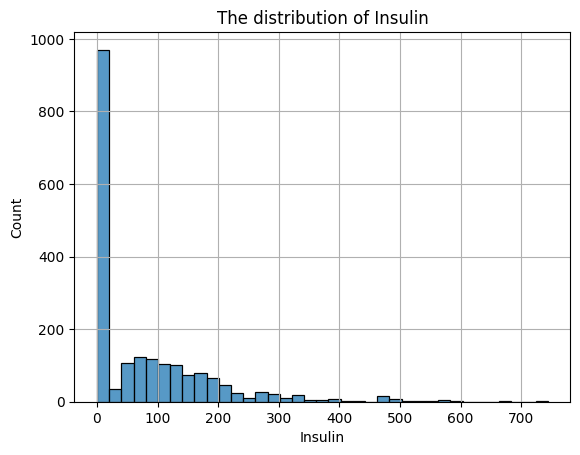

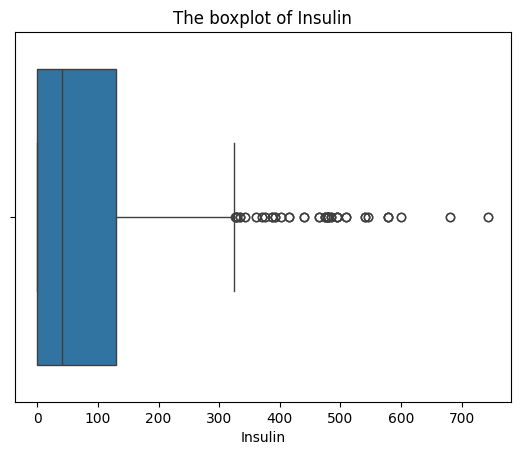

########## Summary Statistics of BMI ############
count   2000.000
mean      32.193
std        8.150
min        0.000
5%        21.800
10%       23.700
20%       26.000
30%       28.300
40%       30.100
50%       32.300
60%       33.800
70%       35.500
80%       38.100
90%       42.100
95%       45.010
100%      80.600
max       80.600
Name: BMI, dtype: float64


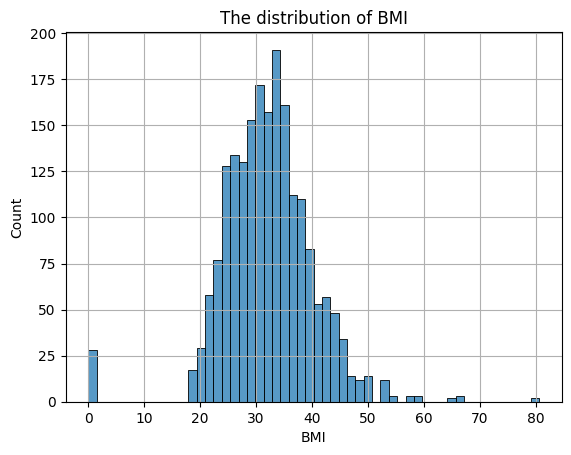

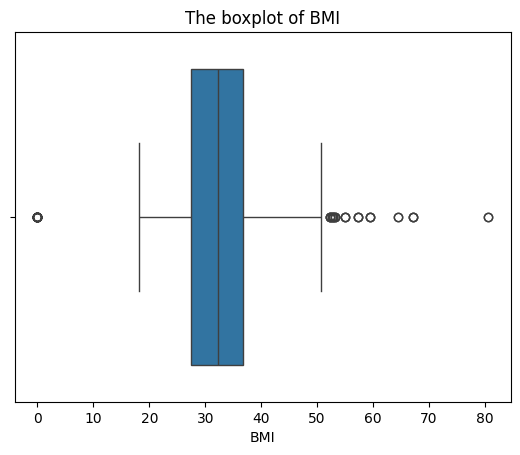

########## Summary Statistics of DiabetesPedigreeFunction ############
count   2000.000
mean       0.471
std        0.324
min        0.078
5%         0.141
10%        0.164
20%        0.222
30%        0.260
40%        0.304
50%        0.376
60%        0.455
70%        0.560
80%        0.687
90%        0.878
95%        1.136
100%       2.420
max        2.420
Name: DiabetesPedigreeFunction, dtype: float64


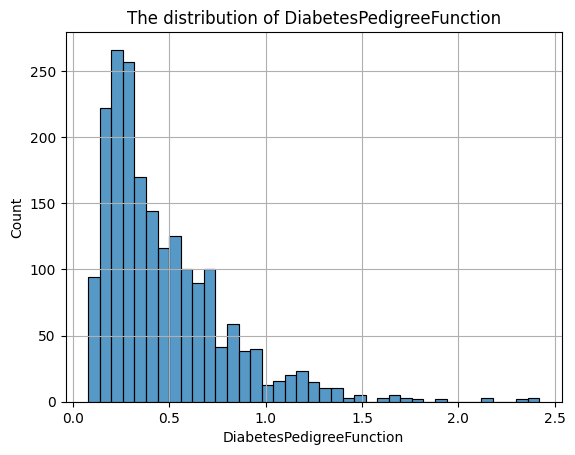

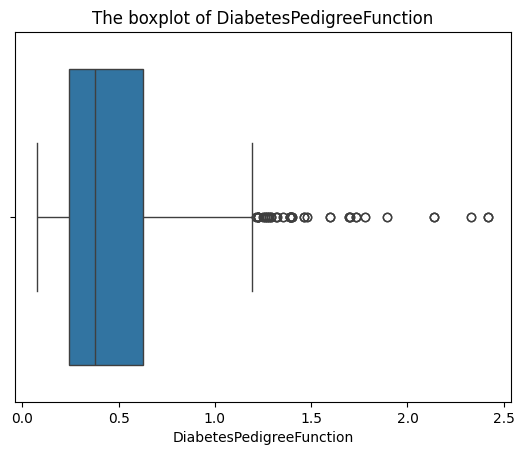

########## Summary Statistics of Age ############
count   2000.000
mean      33.090
std       11.786
min       21.000
5%        21.000
10%       22.000
20%       23.000
30%       25.000
40%       26.000
50%       29.000
60%       33.000
70%       38.000
80%       42.000
90%       50.000
95%       58.000
100%      81.000
max       81.000
Name: Age, dtype: float64


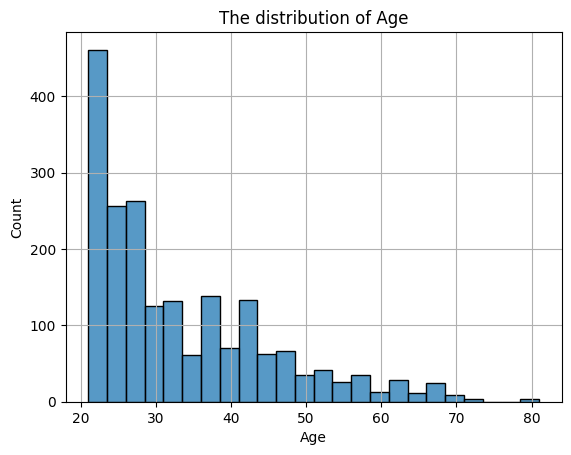

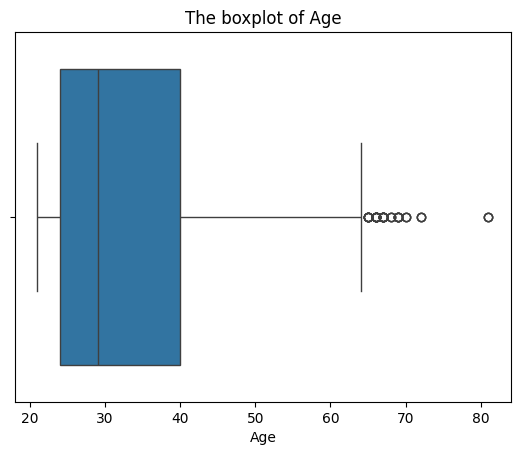

In [12]:
num_summary(df, plot=True)

In [13]:
# lets check to categarical features
def cat_summary(dataframe, plot=False):
    for col in cat_cols:  # cat_cols = grab_col_names(dataframe)["cat_cols"]
        print("############## Frequency of Categorical Data ########################")
        print("The unique number of " + col + ": " + str(dataframe[col].nunique()))
        print(pd.DataFrame({col: dataframe[col].value_counts(),
                            "Ratio": 100* dataframe[col].value_counts() / len(dataframe)}))
        if plot: # plot is True (Default)
            if dataframe[col].dtypes == "bool":  # plot function not working when data type is bool
                dataframe[col] == dataframe[col].astype(int)
                sns.countplot(x=dataframe[col], data=dataframe)
                plt.show(block=True)
            else:
                sns.countplot(x=dataframe[col], data=dataframe)
                plt.show(block=True)

############## Frequency of Categorical Data ########################
The unique number of Outcome: 2
         Outcome  Ratio
Outcome                
0           1316 65.800
1            684 34.200


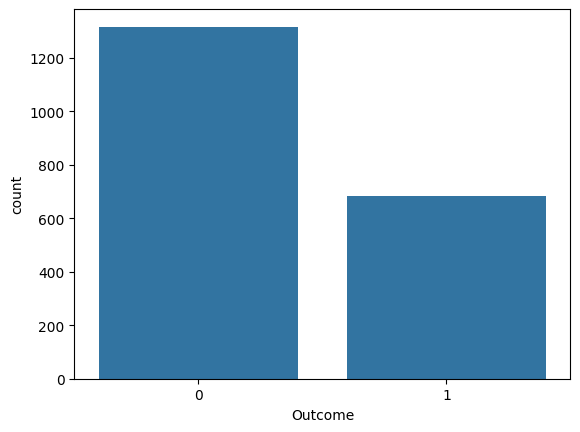

In [14]:
cat_summary(df,plot=True)

## According to data 1316 people are not affilated by disease and 684 people are affilated by it 

In [15]:
# lets analyze the target variable
df.groupby("Outcome").agg(["mean", "count"])

Pregnancies       Glucose       BloodPressure       SkinThickness       Insulin          BMI       DiabetesPedigreeFunction          Age      
               mean count    mean count          mean count          mean count    mean count   mean count                     mean count   mean count
Outcome                                                                                                                                               
0             3.726  1316 120.726  1316        69.170  1316        20.735  1316  79.024  1316 32.019  1316                    0.468  1316 33.150  1316
1             3.659   684 122.060   684        69.098   684        21.320   684  82.620   684 32.528   684                    0.476   684 32.975   684

In [16]:
# lets thereshold value check for outliers 
def outlier_thresholds(dataframe,col_name, q1=0.10,q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile
    low_limit = quartile1 - 1.5 * interquartile
    return low_limit, up_limit

In [17]:
for col in num_cols:
    print("####### " + col + " ########")
    print(outlier_thresholds(df, col))

####### Pregnancies ########
(-13.5, 22.5)
####### Glucose ########
(-39.5, 292.5)
####### BloodPressure ########
(3.0, 139.0)
####### SkinThickness ########
(-60.0, 100.0)
####### Insulin ########
(-315.0, 525.0)
####### BMI ########
(-3.900000000000002, 69.7)
####### DiabetesPedigreeFunction ########
(-0.9073000000000003, 1.9495000000000007)
####### Age ########
(-20.0, 92.0)


In [18]:
# lets check outliers in data
def check_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[col_name].lt(low_limit).any() | dataframe[col_name].gt(up_limit).any()

In [19]:
for col in num_cols:
    print(col, check_outliers(df, col))

Pregnancies False
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age False


In [20]:
# lets check if there are any missing values
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0] # Holds columns with missing values in the na_columns variable.
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) # Sort to see columns with the most missing values first.
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # Calculate the ratio of missing values to total values.
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio']) # Concatenate the number of missing values and their ratio.
    print(missing_df, end="\n")
    if na_name: # If na_name is true, return the na_columns variable.
        return na_columns

In [21]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction    Age  Outcome
Pregnancies                     1.000    0.120          0.150         -0.063   -0.077 0.019                    -0.025  0.539   -0.010
Glucose                         0.120    1.000          0.138          0.062    0.320 0.227                     0.123  0.254    0.020
BloodPressure                   0.150    0.138          1.000          0.199    0.087 0.282                     0.051  0.238   -0.002
SkinThickness                  -0.063    0.062          0.199          1.000    0.449 0.394                     0.178 -0.111    0.017
Insulin                        -0.077    0.320          0.087          0.449    1.000 0.223                     0.193 -0.086    0.015
BMI                             0.019    0.227          0.282          0.394    0.223 1.000                     0.126  0.039    0.030
DiabetesPedigreeFunction       -0.025    0.123          0.051          0.178    0.193 0.126                     1.000  0.027    0.012
Age                             0.539    0.254          0.238         -0.111   -0.086 0.039                     0.027  1.000   -0.007
Outcome                        -0.010    0.020         -0.002          0.017    0.015 0.030                     0.012 -0.007    1.000

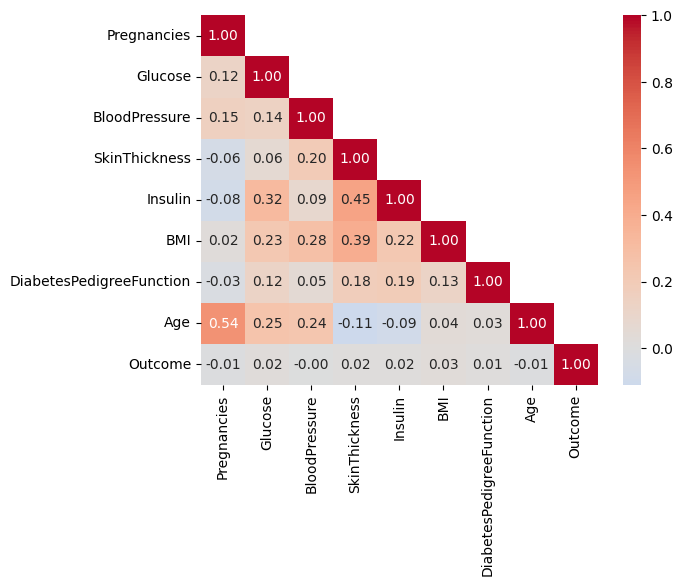

In [22]:
# lets check the correlation between features.
corr_matrix = df.corr()

np.tril(np.ones(corr_matrix.shape)).astype(bool)  #It is used to mark the lower triangular part of the correlation matrix. It takes the lower triangular part and sets the rest to zero.

df_lt = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(bool))# While preserving the values in the triangular section, it sets the other parts as NaN (Not a Number). Thus, only the correlation values within the lower triangular section become df_lt

sns.heatmap(df_lt, cmap="coolwarm",annot=True, fmt=".2f", center=0)
corr_matrix

When we check the graph, we observe that the highest correlation is between the variables of pregnancy-age , glucose-outcome and insulin-skin thickness.

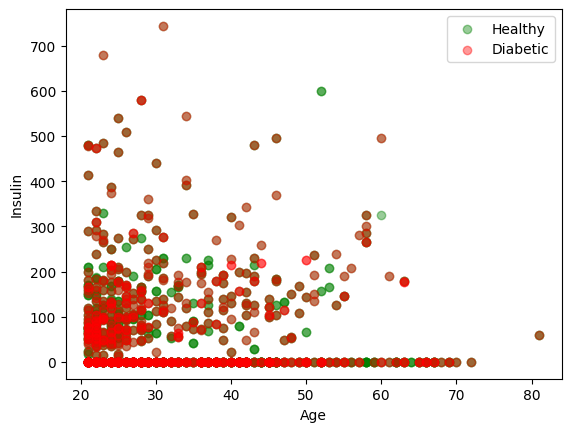

In [23]:
diabetic = df[df.Outcome == 1]
healthy = df[df.Outcome == 0]

plt.scatter(healthy.Age, healthy.Insulin, color="green", label="Healthy", alpha = 0.4)
plt.scatter(diabetic.Age, diabetic.Insulin, color="red", label="Diabetic", alpha = 0.4)
plt.xlabel("Age")
plt.ylabel("Insulin")
plt.legend()
plt.show()

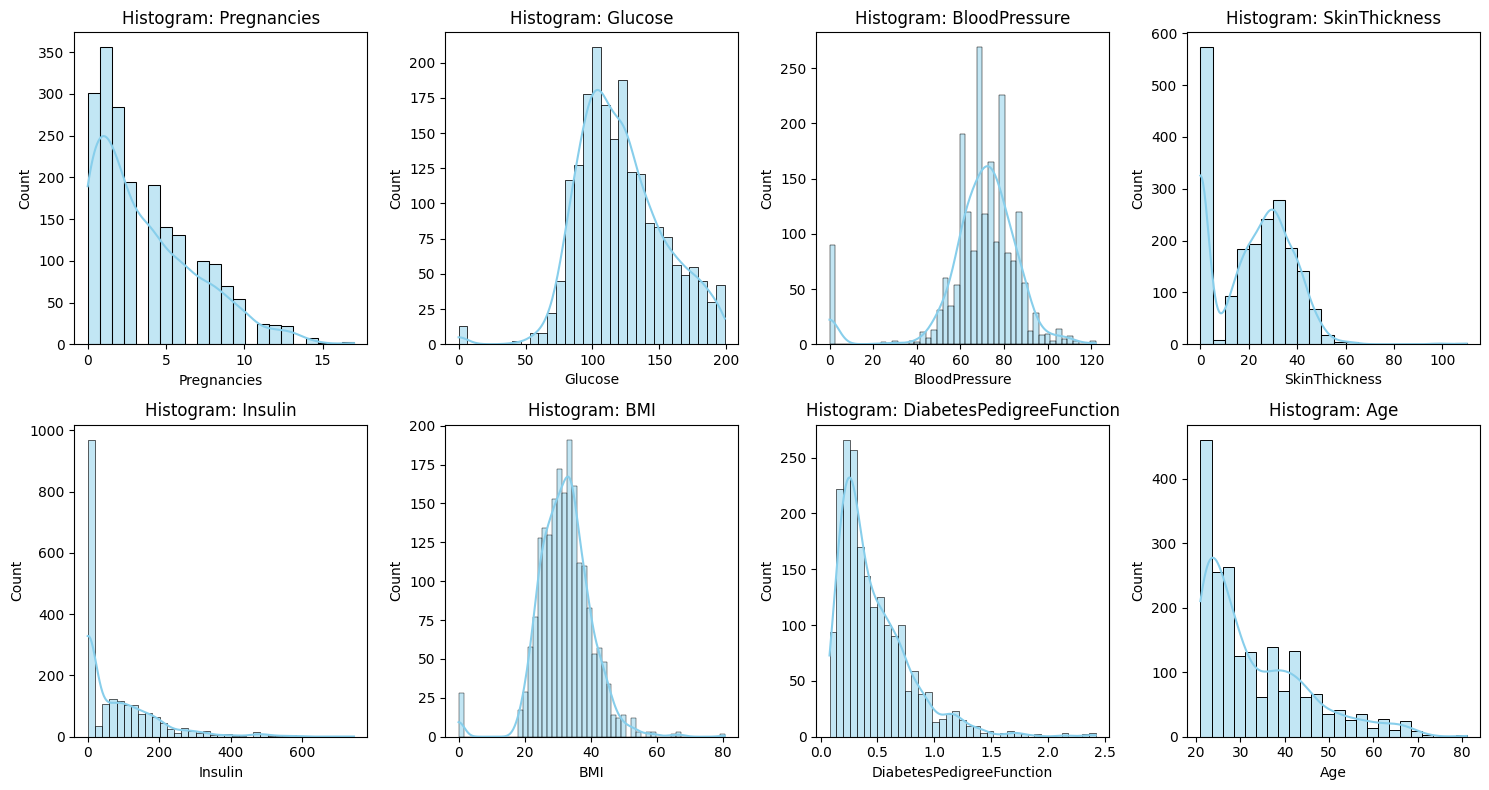

In [24]:
# Extract features for plotting
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram: {feature}')

# Adjust layout
plt.tight_layout()
plt.show()

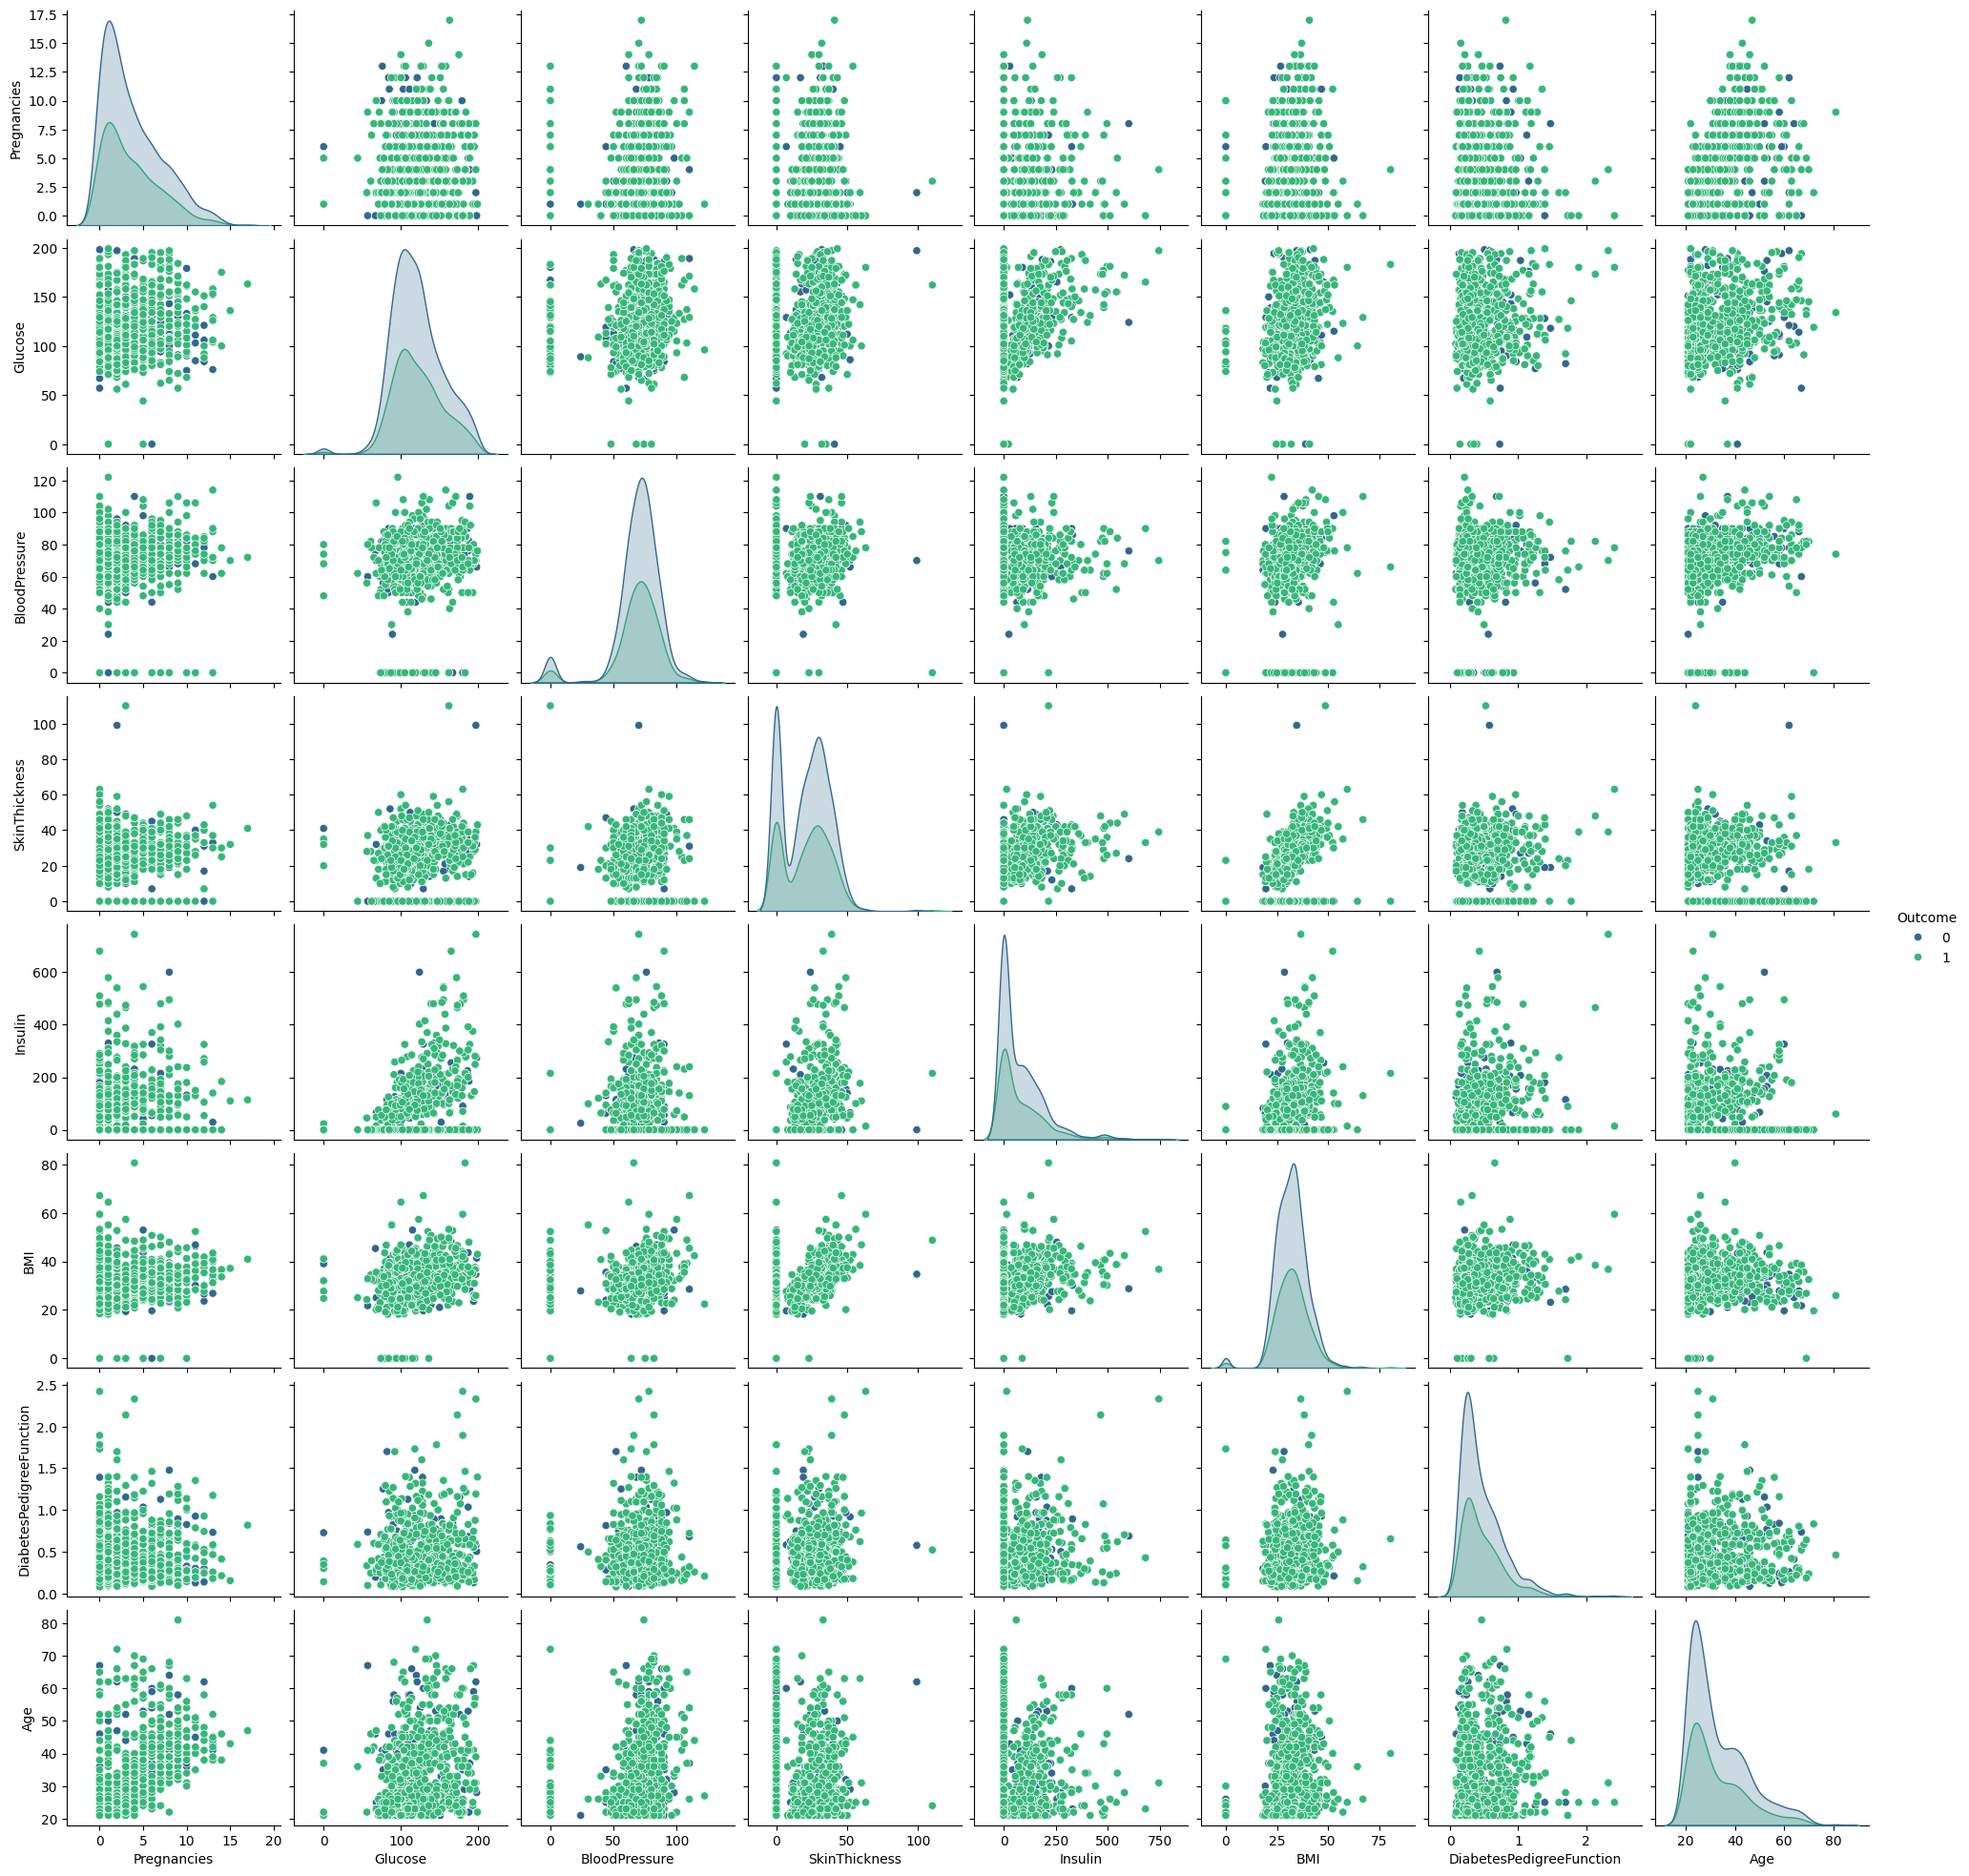

In [25]:
#Extract features for the pair plot
features_for_pair_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Create a pair plot
sns.pairplot(df[features_for_pair_plot], hue='Outcome', diag_kind='kde', palette='viridis')

# Show the plot
plt.show()

In [26]:
df= df_.copy()

# 2. Feature Engineering

In [27]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [28]:
df.describe().T

count    mean     std    min    25%     50%     75%     max
Pregnancies              2000.000   3.704   3.306  0.000  1.000   3.000   6.000  17.000
Glucose                  2000.000 121.183  32.069  0.000 99.000 117.000 141.000 199.000
BloodPressure            2000.000  69.145  19.188  0.000 63.500  72.000  80.000 122.000
SkinThickness            2000.000  20.935  16.103  0.000  0.000  23.000  32.000 110.000
Insulin                  2000.000  80.254 111.181  0.000  0.000  40.000 130.000 744.000
BMI                      2000.000  32.193   8.150  0.000 27.375  32.300  36.800  80.600
DiabetesPedigreeFunction 2000.000   0.471   0.324  0.078  0.244   0.376   0.624   2.420
Age                      2000.000  33.090  11.786 21.000 24.000  29.000  40.000  81.000
Outcome                  2000.000   0.342   0.474  0.000  0.000   0.000   1.000   1.000

## 2.1 Missing Values

On these columns, a value of zero does not make sense and thus indicates missing value.

Following features or variables have an invalid zero value:

* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI

It is better to replace zeros with nan since after that counting them would be easier and zeros need to be replaced with suitable values


In [29]:
df[["Glucose","BloodPressure","SkinThickness","Insulin",
    "BMI"]]=df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.NaN)

In [30]:
df.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

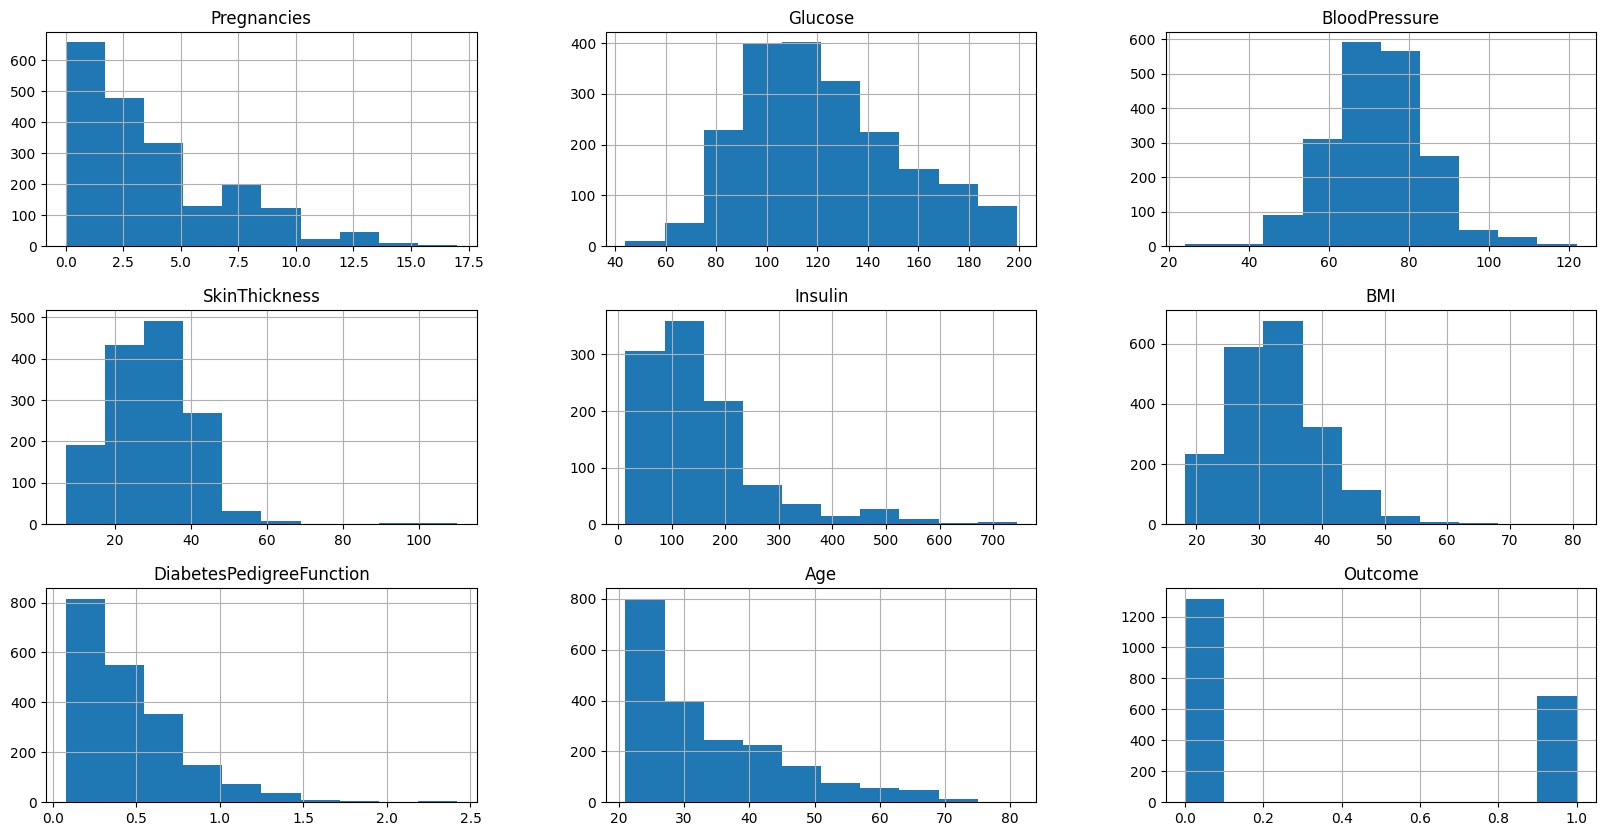

In [31]:
# To fill these Nan values the data distribution needs to be understood
p= df.hist(figsize = (20,10))

In [32]:
missing_values_table(df)

               n_miss  ratio
Insulin           956 47.800
SkinThickness     573 28.650
BloodPressure      90  4.500
BMI                28  1.400
Glucose            13  0.650


In [33]:
# K-Nearest Neighbors (KNN) is a machine learning algorithm that classifies or predicts a new data point based on the majority of its nearest neighbors.
#fill with KNN Imputer method

#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=5)
#columns_to_impute = ["Insulin", "SkinThickness"]
#df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
#df.head()  

# note: model performance dropped to 77 when I using knn method

In [34]:
# Let's fill in the missing values with the mean.

df[["Insulin", 
    "SkinThickness", "Glucose","BloodPressure","BMI"]]= df.groupby("Outcome")[["Insulin", 
                                                                               "SkinThickness",
                                                                               "Glucose","BloodPressure","BMI"]].transform(lambda x: x.fillna(x.mean()))

In [35]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

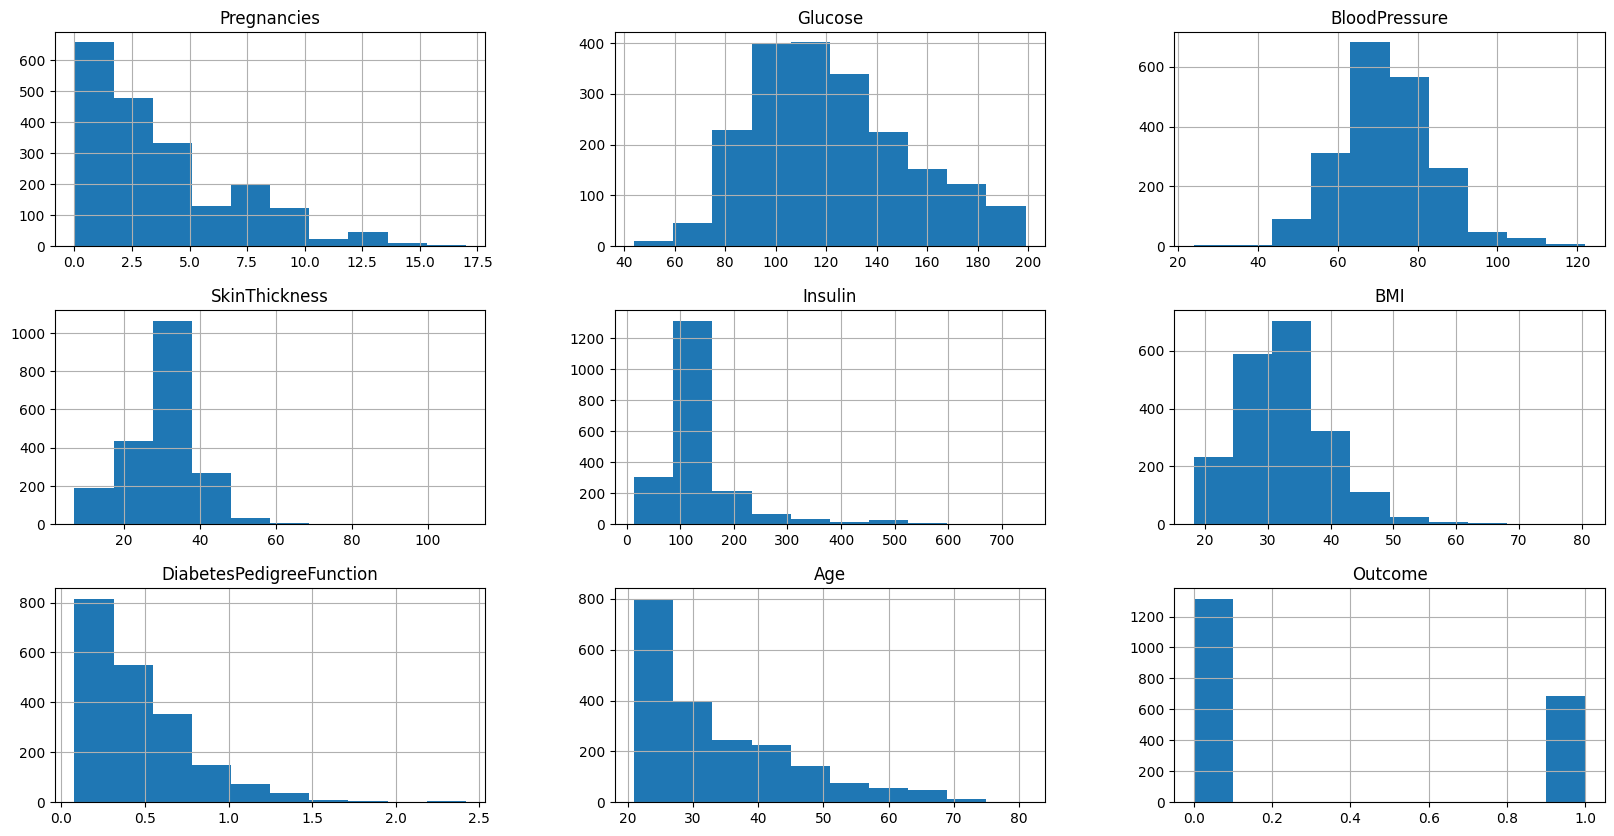

In [36]:
p= df.hist(figsize = (20,10))

In [37]:
for col in df.columns:
    print(col, check_outliers(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age False
Outcome False


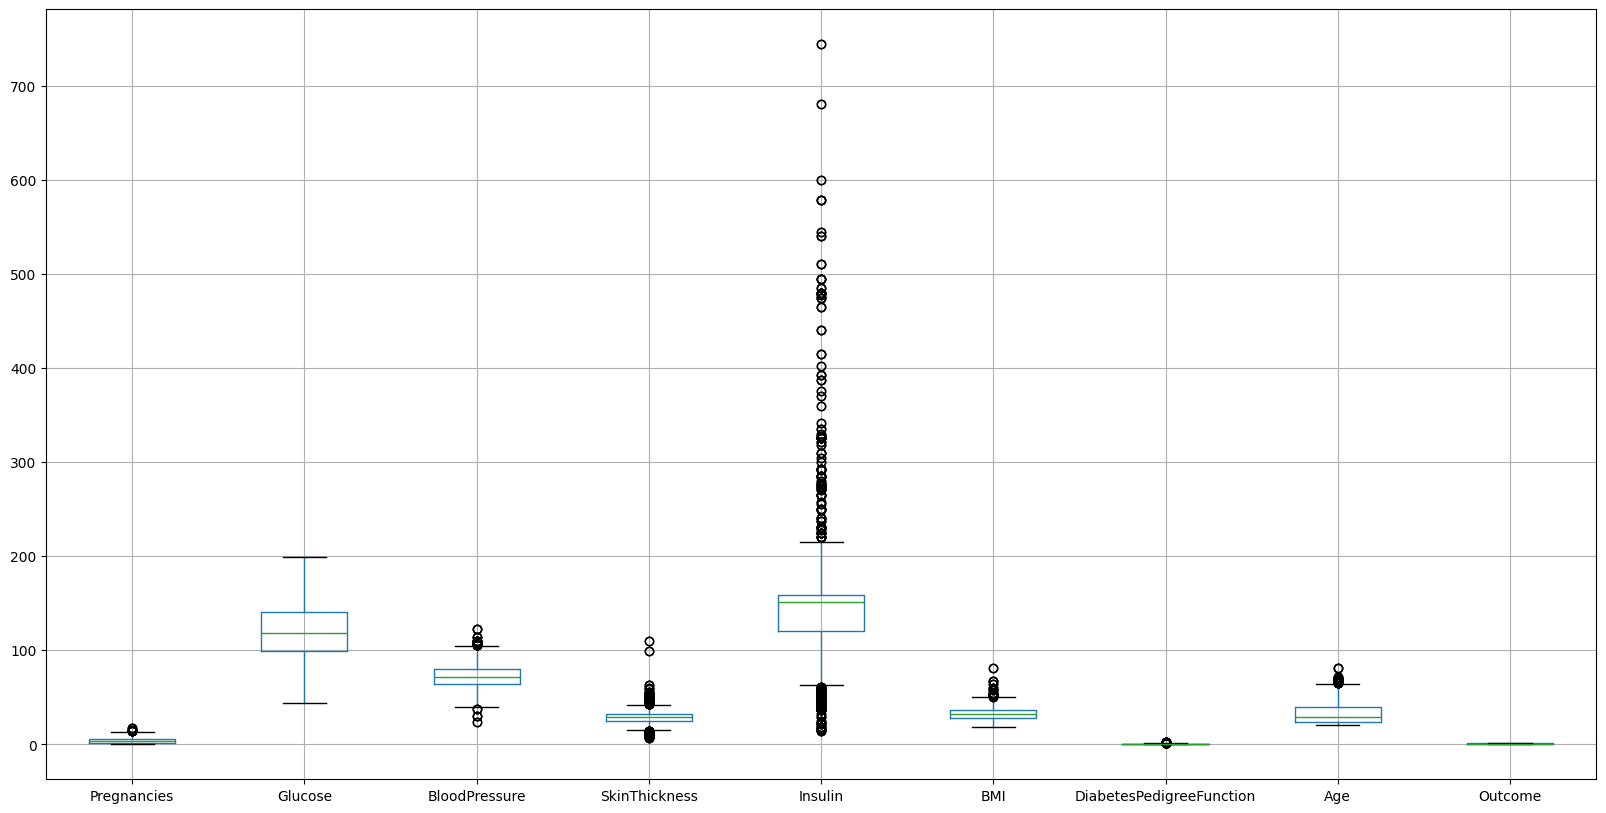

In [38]:
# lets check outliers with boxplot
p= df.boxplot(figsize = (20,10))

**There seem to be outliers in the data. We need to handle them without significantly altering the data structure**

In [39]:
columns_without_target= [col for col in df.columns if col not in "Outcome"]
columns_without_target

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [40]:
#def replace_with_threshold(dataframe, variable):
    #low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.5, q3=0.95) 
     #dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
     #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

In [41]:
 #for col in columns_without_target:
     #replace_with_threshold(df, col)

# when ı used replace_with_threshold accurasy is 0,86

In [42]:
# after replace_with_threshold function check to outlier
 #for col in df.columns:
     #print(col, check_outliers(df, col))

In [43]:
low, up = outlier_thresholds(df,['Pregnancies',
                                 'Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])

df[(df[['Pregnancies',
        'Glucose','BloodPressure','SkinThickness','Insulin',
        'BMI','DiabetesPedigreeFunction','Age']]> up) | (df[['Pregnancies','Glucose','BloodPressure','SkinThickness',
                                                             'Insulin','BMI','DiabetesPedigreeFunction','Age']]< low )].shape

clf= LocalOutlierFactor(n_neighbors=5)  # n_neighborsdefault value 5
clf.fit_predict(df) # fit to method

df_scores = clf.negative_outlier_factor_  
df_scores= -df_scores 
df_scores[0:5]

array([1.03211871, 1.08410265, 0.99740412, 1.10127473, 0.99996808])

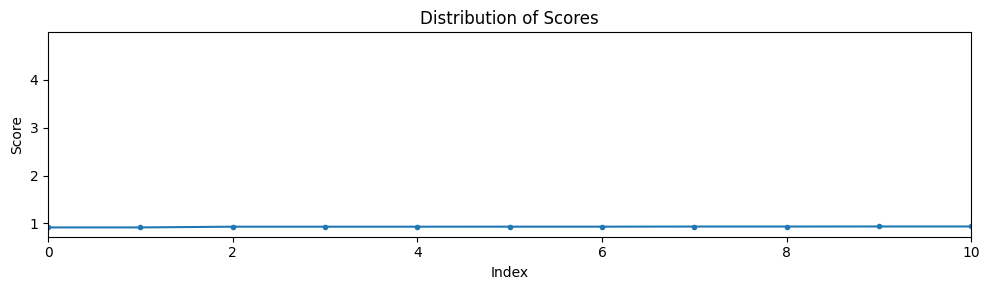

In [44]:
np.sort(df_scores)[0:5] 

scores = pd.DataFrame(np.sort(df_scores))
plt.figure(figsize=(10, 3))  # Adjust the figure size as needed
plt.plot(scores, marker=".", linestyle="-")
plt.title("Distribution of Scores")
plt.xlabel("Index")
plt.ylabel("Score")
plt.xlim([0, 10])
plt.tight_layout()  # Improve spacing between plot elements
plt.show()
#provides the initial and rigid fracture threshold in the distribution.

In [45]:
th= np.sort(df_scores)[3] 
df[df_scores < th]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
675             6  195.000         70.000         29.091  151.157 30.900                     0.328   31        0
1132            6  195.000         70.000         29.091  151.157 30.900                     0.328   31        0

In [46]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

count    mean    std    min     1%     5%     50%     75%     90%     99%     max
Pregnancies              2000.000   3.704  3.306  0.000  0.000  0.000   3.000   6.000   9.000  13.000  17.000
Glucose                  2000.000 121.975 30.533 44.000 67.990 80.000 118.000 141.000 168.000 195.000 199.000
BloodPressure            2000.000  72.404 11.950 24.000 44.000 53.900  72.000  80.000  88.000 106.000 122.000
SkinThickness            2000.000  29.341  9.126  7.000 10.000 14.000  29.091  32.000  40.000  52.000 110.000
Insulin                  2000.000 153.751 80.415 14.000 23.000 50.000 151.157 158.742 210.000 495.000 744.000
BMI                      2000.000  32.651  7.190 18.200 19.500 22.200  32.400  36.800  42.100  52.900  80.600
DiabetesPedigreeFunction 2000.000   0.471  0.324  0.078  0.096  0.141   0.376   0.624   0.878   1.601   2.420
Age                      2000.000  33.090 11.786 21.000 21.000 21.000  29.000  40.000  50.000  67.000  81.000
Outcome                  2000.000   0.342  0.474  0.000  0.000  0.000   0.000   1.000   1.000   1.000   1.000

In [47]:
df[df_scores < th].index

df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            2  138.000         62.000         35.000  151.157 33.600                     0.127   47        0
1            0   84.000         82.000         31.000  125.000 38.200                     0.233   23        0
2            0  145.000         72.359         29.091  151.157 44.200                     0.630   31        0
3            0  135.000         68.000         42.000  250.000 42.300                     0.365   24        0
4            1  139.000         62.000         41.000  480.000 40.700                     0.536   21        0

In [48]:
for col in df.columns:
    print(col, check_outliers(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age False
Outcome False


C:\Users\Soham Lad\AppData\Local\Temp\ipykernel_16996\2766253162.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')


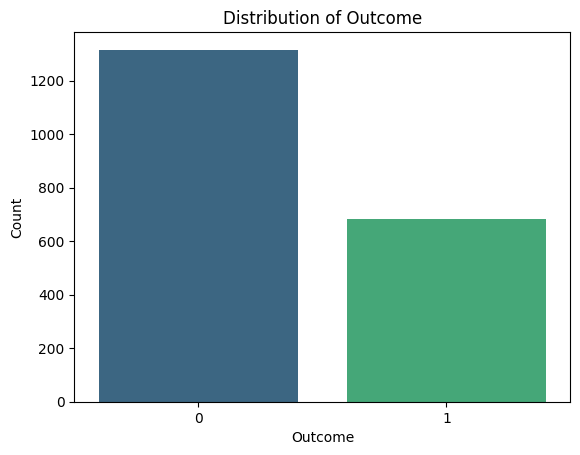

In [49]:
# Count the occurrences of each class in the 'Outcome' column
outcome_counts = df['Outcome'].value_counts()

sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Outcome')
plt.show()

## 2.2 Create New Features

**What is the model's performance if we don't perform any preprocessing on the data, and let's identify the most important variables.**

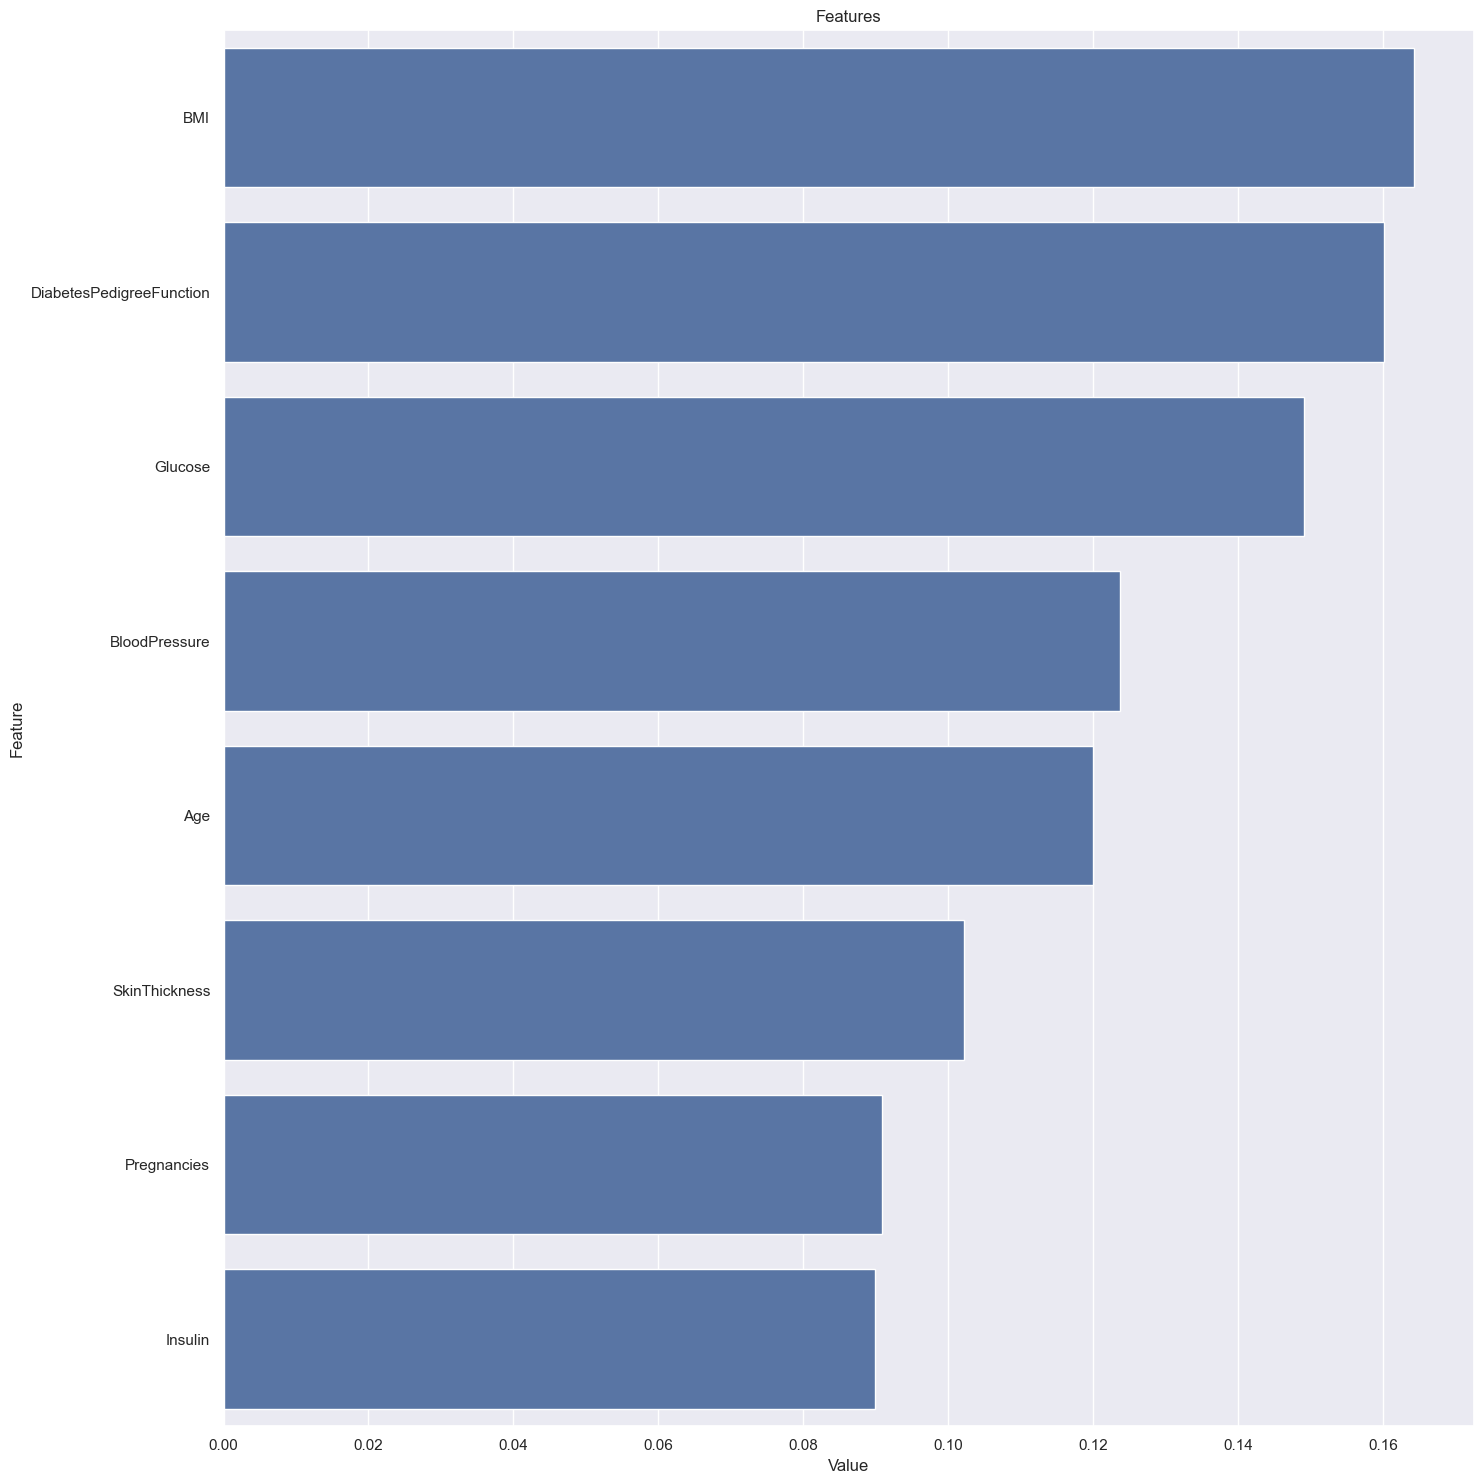

In [50]:
dff = df_.copy()

dff.dropna(inplace=True)
#dff = pd.get_dummies(dff, columns=["Outcome"], drop_first=True)
y = dff["Outcome"]
X = dff.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)   

# result: 0,77

#Features importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

# "We can use these best feature to create new features.
# Glucose, BMI, DiabetesPedigreeFunction

In [51]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype='object')

**I interested in 3 variables that affect the model when we do nothing to the model**
* Glucose
* BMI
* DiabetesPedigreeFunction

In [52]:

df["NEW_GLUCOSEvsBMI"]= df["Glucose"] * df["BMI"]

In [53]:
df["NEW_GLUCOSEvsDPF"] = df["DiabetesPedigreeFunction"] * df["Glucose"]

In [54]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome  NEW_GLUCOSEvsBMI  NEW_GLUCOSEvsDPF
0            2  138.000         62.000         35.000  151.157 33.600                     0.127   47        0          4636.800            17.526
1            0   84.000         82.000         31.000  125.000 38.200                     0.233   23        0          3208.800            19.572
2            0  145.000         72.359         29.091  151.157 44.200                     0.630   31        0          6409.000            91.350
3            0  135.000         68.000         42.000  250.000 42.300                     0.365   24        0          5710.500            49.275
4            1  139.000         62.000         41.000  480.000 40.700                     0.536   21        0          5657.300            74.504

C:\Users\Soham Lad\AppData\Local\Temp\ipykernel_16996\3723474293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Outcome', y='NEW_GLUCOSEvsBMI', data=df, palette='viridis')


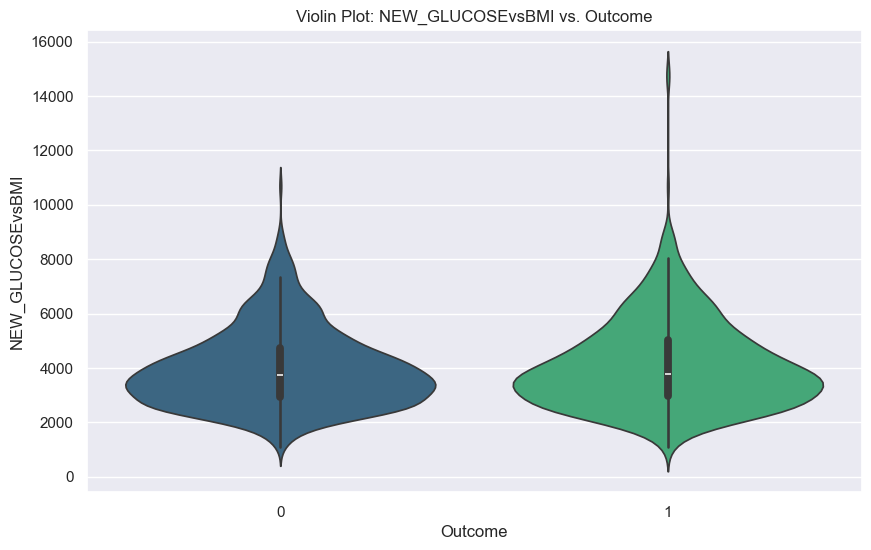

In [55]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Outcome', y='NEW_GLUCOSEvsBMI', data=df, palette='viridis')
plt.title('Violin Plot: NEW_GLUCOSEvsBMI vs. Outcome')
plt.xlabel('Outcome')
plt.ylabel('NEW_GLUCOSEvsBMI')
plt.show()

C:\Users\Soham Lad\AppData\Local\Temp\ipykernel_16996\3524948256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Outcome', y='NEW_GLUCOSEvsDPF', data=df, palette='viridis')


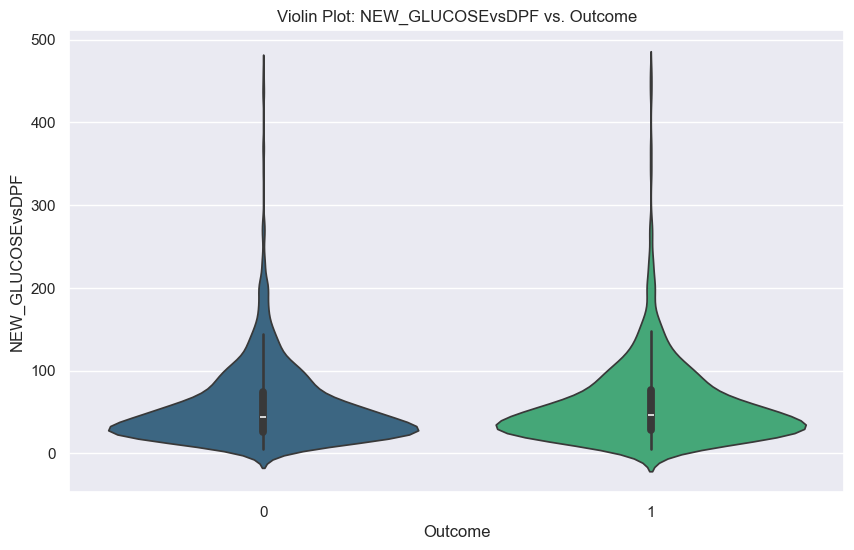

In [56]:
# Violin plot for NEW_GLUCOSEvsDPF
plt.figure(figsize=(10, 6))
sns.violinplot(x='Outcome', y='NEW_GLUCOSEvsDPF', data=df, palette='viridis')
plt.title('Violin Plot: NEW_GLUCOSEvsDPF vs. Outcome')
plt.xlabel('Outcome')
plt.ylabel('NEW_GLUCOSEvsDPF')
plt.show()

**Let's classify numerical features**

In [57]:
df["Age"].describe()

count   2000.000
mean      33.090
std       11.786
min       21.000
25%       24.000
50%       29.000
75%       40.000
max       81.000
Name: Age, dtype: float64

In [58]:
df.groupby("Outcome").agg({"Age" : ["mean", "count"]})

Age      
          mean count
Outcome             
0       33.150  1316
1       32.975   684

In [59]:
df.loc[(df["Age"]< 25),"NEW_AGE_CAT" ]= "young"
df.loc[((df["Age"]>= 25 ) & (df["Age"]< 55)),"NEW_AGE_CAT" ]= "mature"
df.loc[(df["Age"]>= 55),"NEW_AGE_CAT" ] = "senior"

In [60]:
df.groupby("NEW_AGE_CAT").agg({"Outcome" : ["mean", "count"]})

Outcome      
               mean count
NEW_AGE_CAT              
mature        0.345  1276
senior        0.326   141
young         0.340   583

In [61]:
df.loc[(df["BMI"]< 18.5 ),"NEW_BMI_CAT" ]= "underweight"
df.loc[((df["BMI"]>= 18.5 ) & (df["BMI"]< 24.9)),"NEW_BMI_CAT" ]= "normal"
df.loc[((df["BMI"]>= 24.9 ) & (df["BMI"]< 29.9)),"NEW_BMI_CAT" ]= "Fat"
df.loc[((df["BMI"]>= 24.9 ) & (df["BMI"]< 34.9)),"NEW_BMI_CAT" ]= "1st_obesity"
df.loc[(df["BMI"]>= 34.9),"NEW_BMI_CAT" ] = "1st_obesity"

In [62]:
df.groupby("NEW_BMI_CAT").agg({"Outcome" : ["mean", "count"]})

Outcome      
               mean count
NEW_BMI_CAT              
1st_obesity   0.344  1737
normal        0.328   253
underweight   0.400    10

In [63]:
df.groupby("Outcome").agg({"Glucose" : ["mean", "count"]})

Glucose      
           mean count
Outcome              
0       121.558  1316
1       122.778   684

In [64]:
df["Glucose"].describe()

count   2000.000
mean     121.975
std       30.533
min       44.000
25%       99.000
50%      118.000
75%      141.000
max      199.000
Name: Glucose, dtype: float64

In [65]:
df.loc[(df["Glucose"]< 70),"NEW_GLUCOSE_CAT" ]= "low"
df.loc[((df["Glucose"]>= 70 ) & (df["Glucose"]< 140)),"NEW_GLUCOSE_CAT" ]= "normal"
df.loc[(df["Glucose"]>= 140),"NEW_GLUCOSE_CAT" ] = "up"

In [66]:
df.groupby("NEW_GLUCOSE_CAT").agg({"Outcome" : ["mean", "count"]})

Outcome      
                   mean count
NEW_GLUCOSE_CAT              
low               0.296    27
normal            0.336  1451
up                0.360   522

In [67]:
df.loc[(df["Pregnancies"]== 0),"HAVE_CHILDREN" ]= "NO"
df.loc[(df["Pregnancies"] > 0),"HAVE_CHILDREN" ]= "YES"

In [68]:
df.groupby("HAVE_CHILDREN").agg({"Outcome" : ["mean", "count"]})

Outcome      
                 mean count
HAVE_CHILDREN              
NO              0.346   301
YES             0.341  1699

In [69]:
df["Insulin"].describe()

count   2000.000
mean     153.751
std       80.415
min       14.000
25%      120.000
50%      151.157
75%      158.742
max      744.000
Name: Insulin, dtype: float64

In [70]:
df.loc[(df["Insulin"]< 140),"NEW_INSULIN_CAT" ]= "nondiebet"
df.loc[((df["Insulin"]>= 140 ) & (df["Insulin"]< 199)),"NEW_INSULIN_CAT" ]= "prediyabet"
df.loc[(df["Insulin"]>= 199),"NEW_INSULIN_CAT" ] = "diabet"

In [71]:
df.groupby("NEW_INSULIN_CAT").agg({"Outcome" : ["mean", "count"]})

Outcome      
                   mean count
NEW_INSULIN_CAT              
diabet            0.370   235
nondiebet         0.332   579
prediyabet        0.341  1186

In [72]:
df["BloodPressure"].describe()

count   2000.000
mean      72.404
std       11.950
min       24.000
25%       64.000
50%       72.000
75%       80.000
max      122.000
Name: BloodPressure, dtype: float64

In [73]:
df.loc[(df["BloodPressure"]< 75 ),"NEW_BLOODPRESSURE_CAT" ]= "low"
df.loc[((df["BloodPressure"]>= 75 ) & (df["BloodPressure"]<= 125)),"NEW_BLOODPRESSURE_CAT" ]= "normal"
df.loc[(df["BloodPressure"]> 125),"NEW_BLOODPRESSURE_CAT" ] = "high"

In [74]:
df.groupby("NEW_BLOODPRESSURE_CAT").agg({"Outcome" : ["mean", "count"]})

Outcome      
                         mean count
NEW_BLOODPRESSURE_CAT              
low                     0.345  1236
normal                  0.338   764

## 2.3 Encoding

In [75]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome  NEW_GLUCOSEvsBMI  NEW_GLUCOSEvsDPF NEW_AGE_CAT  NEW_BMI_CAT NEW_GLUCOSE_CAT HAVE_CHILDREN NEW_INSULIN_CAT NEW_BLOODPRESSURE_CAT
0            2  138.000         62.000         35.000  151.157 33.600                     0.127   47        0          4636.800            17.526      mature  1st_obesity          normal           YES      prediyabet                   low
1            0   84.000         82.000         31.000  125.000 38.200                     0.233   23        0          3208.800            19.572       young  1st_obesity          normal            NO       nondiebet                normal
2            0  145.000         72.359         29.091  151.157 44.200                     0.630   31        0          6409.000            91.350      mature  1st_obesity              up            NO      prediyabet                   low
3            0  135.000         68.000         42.000  250.000 42.300                     0.365   24        0          5710.500            49.275       young  1st_obesity          normal            NO          diabet                   low
4            1  139.000         62.000         41.000  480.000 40.700                     0.536   21        0          5657.300            74.504       young  1st_obesity          normal           YES          diabet                   low

In [76]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2000
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 1


In [77]:
# Label Encoder is a data transformation method that converts text-based or categorical features into numerical data by assigning different numerical labels such as 0, 1, 2 to each unique category.

def label_encoder(dataframe, binary_col): 
    labelencoder= LabelEncoder()  # called label encoder
    dataframe[binary_col]= labelencoder.fit_transform(dataframe[binary_col]) # fitting to label encoder
    return dataframe

In [78]:
for col in cat_cols:
    label_encoder(df, col)

In [79]:
# MinMax Scaler is a feature scaling method that rescales the data to a specific range (typically [0, 1]).

def min_max_scaler(dataframe, num_cols):
    for col in num_cols:
        mms= MinMaxScaler()
        df[col + "MIN_MAX_SCALER"]= mms.fit_transform(df[[col]])

min_max_scaler(df,num_cols)


In [80]:
# Robust Scaler is a feature scaling method that scales the data using the median and interquartile range, making it resistant to outliers.

def robust_scaler(dataframe, num_col):
    for col in num_cols:
        rs= RobustScaler()
        df[col]= rs.fit_transform(df[[col]])

#robust_scaler(df, num_cols)
# when ı used scae to Robust method model accuracy=0,87

In [81]:
# Standart Scaler is a feature scaling method that scales the data to have a mean of 0 and a standard deviation of 1.

def standrt_scaler(dataframe, num_cols):
    for col in num_cols:
        ss= StandardScaler()
        df[col]= ss.fit_transform(df[[col]])

#standrt_scaler(df, num_cols)
# when ı used scae to standart scaler method model accuracy=0,87

**I tried 3 scaler methods, but nothing changed in the data**

(768 observation)

* 0.87--> Minmax scaler
* 0.87-->Robust scaler 
* 0.87--> Standart scaler 

When the same score is obtained for all different scaling methods (MinMax Scaler, Robust Scaler, and Standard Scaler), it is likely due to the similarity in data distribution and structural features. Such situations arise when the impact of the scaling process is limited or similar.

In [82]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome  NEW_GLUCOSEvsBMI  NEW_GLUCOSEvsDPF  NEW_AGE_CAT  NEW_BMI_CAT  NEW_GLUCOSE_CAT  HAVE_CHILDREN  NEW_INSULIN_CAT  NEW_BLOODPRESSURE_CAT  PregnanciesMIN_MAX_SCALER  GlucoseMIN_MAX_SCALER  BloodPressureMIN_MAX_SCALER  SkinThicknessMIN_MAX_SCALER  InsulinMIN_MAX_SCALER  BMIMIN_MAX_SCALER  DiabetesPedigreeFunctionMIN_MAX_SCALER  AgeMIN_MAX_SCALER  NEW_GLUCOSEvsBMIMIN_MAX_SCALER  \
0            2  138.000         62.000         35.000  151.157 33.600                     0.127   47        0          4636.800            17.526            0            0                1              1                2                      0                      0.118                  0.606                        0.388                        0.272                  0.188              0.247                                   0.021              0.433                           0.259   
1            0   84.000         82.000         31.000  125.000 38.200                     0.233   23        0          3208.800            19.572            2            0                1              0                1                      1                      0.000                  0.258                        0.592                        0.233                  0.152              0.321                                   0.066              0.033                           0.154   
2            0  145.000         72.359         29.091  151.157 44.200                     0.630   31        0          6409.000            91.350            0            0                2              0                2                      0                      0.000                  0.652                        0.493                        0.214                  0.188              0.417                                   0.236              0.167                           0.389   
3            0  135.000         68.000         42.000  250.000 42.300                     0.365   24        0          5710.500            49.275            2            0                1              0                0                      0                      0.000                  0.587                        0.449                        0.340                  0.323              0.386                                   0.123              0.050                           0.338   
4            1  139.000         62.000         41.000  480.000 40.700                     0.536   21        0          5657.300            74.504            2            0                1              1                0                      0                      0.059                  0.613                        0.388                        0.330                  0.638              0.361                                   0.196              0.000                           0.334   

   NEW_GLUCOSEvsDPFMIN_MAX_SCALER  
0                           0.027  
1                           0.031  
2                           0.189  
3                           0.097  
4                           0.152

In [83]:
df.shape

(2000, 27)

## 3. Modelling with RandomForestClassifier

In [84]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Model
##################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=17).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.73

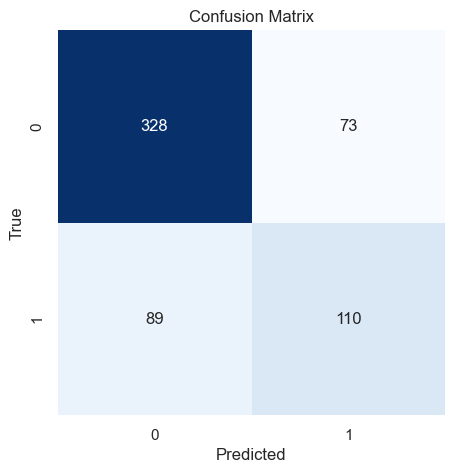

In [85]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The model gives an accuracy of 73%

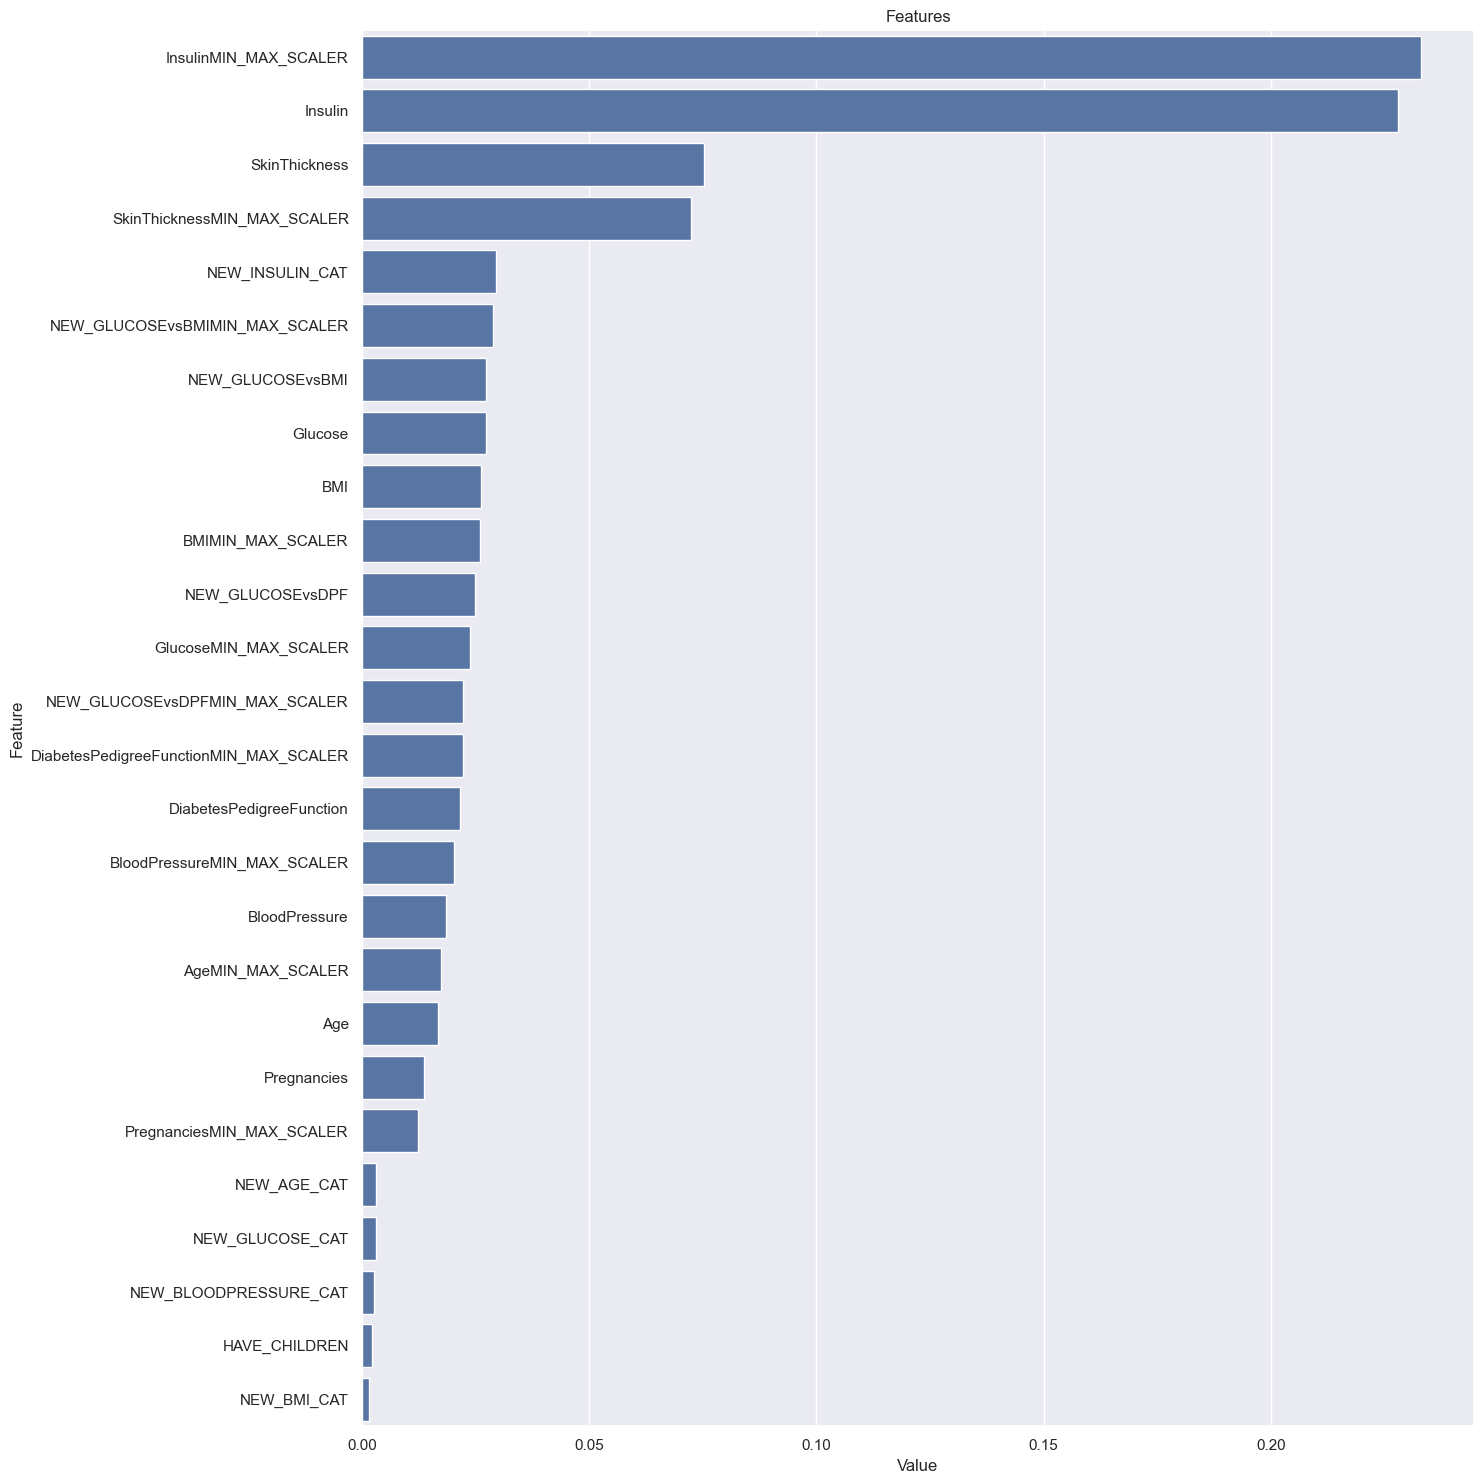

In [86]:
#Features importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

Conclusions:
1. The diabetes prediction model achieved a 73% accuracy rate.
2. Key features identified include "insulin" and "insulin_max_min_scalar."
3. "Insulin" underscores its crucial role in predicting diabetes outcomes, emphasizing its impact on blood sugar regulation.
4. The inclusion of "insulin_max_min_scalar" highlights the significance of feature scaling in optimizing model performance.
5. Further refinement and exploration of additional features are suggested to enhance predictive capabilities.
6. The success of feature engineering techniques, particularly in normalizing insulin values, contributes to the model's effectiveness.
7. The model underscores the critical influence of insulin levels on diabetes prediction.

In [87]:
# Save the trained model to a file using pickle
import pickle
with open("diabetes_rf_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

In [89]:
# # Importing necessary libraries
# import pickle
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Assuming 'X' is your feature matrix and 'y' is your target variable
# # Splitting the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the scaler object
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Saving the scaler object using pickle
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

# # Creating and training the Random Forest model
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train_scaled, y_train)

# # Making predictions
# y_pred = rf_model.predict(X_test_scaled)

# # Evaluating the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
